## Semantic Song Search: Fine-Tune Base Model

In [ ]:
# check system specs

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print('Connected to a GPU')

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9

if ram_gb < 20:
  print('Not using a high-RAM runtime: {:.1f} gigabytes of available RAM'.format(ram_gb))
else:
  print('Using a high-RAM runtime: {:.1f} gigabytes of available RAM'.format(ram_gb))

Connected to a GPU
Using a high-RAM runtime: 89.6 gigabytes of available RAM


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# note: place shortcut to shared project folder in google drive root directory
%cd /content/gdrive/MyDrive/ml2_project

/content/gdrive/.shortcut-targets-by-id/1WHLBzPq6pt_F7mh3d3goIQl4MwYlTfIh/ml2_project


## Data Prep
Note: can skip data prep once train/val/test sets have been created

In [ ]:
df = pd.read_csv('data/clean_dataset.csv')

#### Remove rap because we don't like the lyrics
- Too explicit / NSFW / NSFS
- Many similar lines, less cohesive narratives/plots
- Concern: Some rap songs are tagged as pop

In [ ]:
df['tag'].unique()

array(['rap', 'rb', 'rock', 'pop', 'misc', 'country'], dtype=object)

In [ ]:
df = df[df['tag'] != 'rap']
df.shape

(95072, 10)

In [ ]:
# all
lyrics = df['lyrics']

In [ ]:
lyrics.shape

(95072,)

### Remove duplicate lyrics lines
- Remove duplicate lines because otherwise our model may learn to match song halves based on repeated lyrics within a song
- Define function below to dedupe and preserve order
- Concern: There can still be quite similar lines scattered through songs

In [ ]:
# remove duplicates from list and preserve order
def dedupe(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [ ]:
# process dataset

lyrics_deduped = []

for song in lyrics:
    song = dedupe(str(song).split('\n'))
    song = '\n'.join(song)
    lyrics_deduped.append(song)

In [ ]:
# create train/validation/test dataset splits

import random

np.random.seed(20221206)
train = np.random.choice([True,False], size=len(lyrics_deduped), p=[0.8,0.2])
test = np.invert(train)

lyrics_train = pd.Series(lyrics_deduped)[train]
lyrics_test = pd.Series(lyrics_deduped)[test]

lyrics_test2 = lyrics_test[:len(lyrics_test)//2]
lyrics_val = lyrics_test[len(lyrics_test)//2:]

lyrics_train.to_csv("data/lyrics_train.csv")
lyrics_test2.to_csv("data/lyrics_test.csv")
lyrics_val.to_csv("data/lyrics_val.csv")

### Training

In [ ]:
# load train/validation datasets

lyrics_train = pd.read_csv('data/lyrics_train.csv',names = ['index','lyrics'])
lyrics_train = lyrics_train['lyrics']

lyrics_val = pd.read_csv('data/lyrics_val.csv',names = ['index','lyrics'])
lyrics_val = lyrics_val['lyrics']

Reference: https://www.pinecone.io/learn/fine-tune-sentence-transformers-mnr/#fast-fine-tuning

In [ ]:
!pip install sentence_transformers

In [ ]:
# prep training data

from sentence_transformers import InputExample

train_samples = []
val_samples = []

for song in lyrics_train:
    # split songs into two halves for positive pair training
    song = str(song)
    half_1 = song[:len(song)//2]
    half_2 = song[len(song)//2:]
    train_samples.append(InputExample(
        texts=[half_1, half_2]
    ))

for song in lyrics_val[:1000]:
    song = str(song)
    half_1 = song[:len(song)//2]

    #validate on 50/50 positive/negative
    label = np.random.choice([0,1])
    if label == 0:
      half_2_song = np.random.choice(lyrics_test)
    else:
      half_2_song = song

    half_2 = half_2_song[len(song)//2:]
    val_samples.append(InputExample(
        texts=[half_1, half_2],
        label = label
    ))

In [ ]:
# set evaluator during training

from sentence_transformers.evaluation import BinaryClassificationEvaluator, SimilarityFunction

evaluator_val = BinaryClassificationEvaluator.from_input_examples(
    val_samples, write_csv=False, 
    main_similarity = SimilarityFunction.COSINE
)

In [ ]:
from sentence_transformers import datasets

batch_size = 32

# removes duplicate pairings
loader = datasets.NoDuplicatesDataLoader(
    train_samples, batch_size=batch_size)

In [ ]:
from sentence_transformers import models, SentenceTransformer
import torch

# model = SentenceTransformer('all-MiniLM-L12-v2')
# model.save('./all-MiniLM-L12-v2')
model = SentenceTransformer('./models/all-MiniLM-L12-v2')
#model.max_seq_length = 510
model = model.to(torch.device('cuda')) # use GPU

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [ ]:
# specify loss

from sentence_transformers import losses

# mnr loss
loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
# model name for export/save
model_export_name = './models/new_model2'

In [ ]:
type(model)

sentence_transformers.SentenceTransformer.SentenceTransformer

In [ ]:
scores_at_50_steps = [evaluator_val(model)]

def print_callback(score, epoch, steps):
  print("Score of {} after {} steps".format(score,steps))
  scores_at_50_steps.append(score)

In [ ]:
# train and export model

epochs = 1
warmup_steps = int(len(loader) * epochs * 0.1)

model.fit(
    train_objectives=[(loader, loss)],
    epochs=epochs,
    steps_per_epoch = 1500,
    evaluator = evaluator_val,
    evaluation_steps = 50,
    warmup_steps=warmup_steps,
    output_path=model_export_name,
    show_progress_bar=True,
    callback = print_callback
) 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1500 [00:00<?, ?it/s]

Score of 0.8128678732380059 after 50 steps
Score of 0.8274028653307464 after 100 steps
Score of 0.8416606043554328 after 150 steps
Score of 0.8475245067447787 after 200 steps
Score of 0.8484533045227602 after 250 steps
Score of 0.8504148699792436 after 300 steps
Score of 0.8498118445562257 after 350 steps
Score of 0.8535270356681518 after 400 steps
Score of 0.852709139117392 after 450 steps
Score of 0.8527645897310028 after 500 steps
Score of 0.8551558974429702 after 550 steps
Score of 0.8551489661162688 after 600 steps
Score of 0.8558420987864043 after 650 steps
Score of 0.8533260271938125 after 700 steps
Score of 0.8555093951047392 after 750 steps
Score of 0.8556688156188703 after 800 steps
Score of 0.8574709605612225 after 850 steps
Score of 0.8573254027004941 after 900 steps
Score of 0.8572352954533764 after 950 steps
Score of 0.8578521835297971 after 1000 steps
Score of 0.8569996329165321 after 1050 steps
Score of 0.8558628927665083 after 1100 steps
Score of 0.8566877206439695 aft

After training on the entire dataset. we see that actually the model starts overfitting before a complete pass, so to prevent overfitting we use the model trained at 1800 steps

In [ ]:
import matplotlib.pyplot as plt

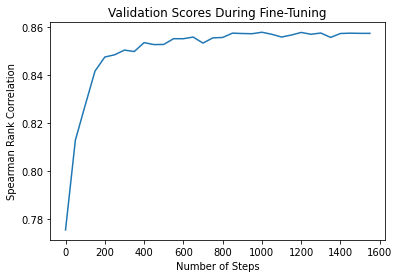

In [ ]:
x_axis = [i*50 for i in range(len(scores_at_50_steps))]
plt.plot(x_axis, scores_at_50_steps);
plt.xlabel("Number of Steps")
plt.ylabel("Spearman Rank Correlation")
plt.title("Validation Scores During Fine-Tuning")
plt.show()